# Retrospective estimator example

In [2]:
import pyspark.sql.functions as F
import pysparkling
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from upliftml.models.h2o import RetrospectiveEstimator
from upliftml.evaluation import (
    estimate_roi,
    estimate_iroi,
    estimate_and_plot_iroi_per_bucket,
    estimate_and_plot_iroi_per_quantile,
    estimate_and_plot_cum_iroi,
    plot_metric_per_bucket,
    plot_cum_iroi
)
from upliftml.datasets import simulate_randomized_trial

### Start H2O

In [ ]:
context = pysparkling.H2OContext.getOrCreate()

#### Plot style

In [4]:
sns.set(font_scale=1.5, style='ticks', rc={'figure.figsize':(11, 7)})

### Read dataframe

In [5]:
df_pd = simulate_randomized_trial(n=2000, p=6, sigma=1.0, binary_outcome=True, add_cost_benefit=True)
df_spark = spark.createDataFrame(df_pd)

In [6]:
df_spark.cache().count()

2000

In [7]:
df_spark.limit(5).toPandas()

,treatment,outcome,propensity,expected_outcome,actual_cate,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,benefit,cost
0,1,1,0.5,2.019253,0.180605,1.014769,-0.857720,-2.131140,1.430432,0.588821,1.038366,4.405101,1.101275
1,1,1,0.5,0.000000,-0.268418,-1.883508,-0.832102,-0.581922,-0.084271,-0.416903,0.785944,4.614017,1.153504
2,1,1,0.5,0.000000,0.435552,-1.478967,0.280614,-0.181815,-1.098660,-0.161005,-0.198284,0.785181,0.196295
3,1,1,0.5,1.511113,0.566909,1.554448,-0.809237,-0.328511,-0.379553,1.473966,-0.188883,0.989232,0.247308
4,0,0,0.5,0.199959,0.542356,0.573215,0.474320,-1.170482,-0.755163,0.955122,1.904021,0.000000,0.000000


### Estimate ROI

In [8]:
results = estimate_roi(df_spark,
                       benefit_colname='benefit',
                       cost_colname='cost',
                       bootstrap=True,
                       n_bootstraps=100,
                       ci_quantiles=[0.025, 0.975])

print('ROI: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(results['roi'], results['roi_lower'], results['roi_upper']))

ROI: 7.3039, lower: 6.8842, upper: 7.7141


### Estimate incremental ROI

In [9]:
results = estimate_iroi(df_spark,
                        benefit_colname='benefit',
                        cost_colname='cost',
                        treatment_colname='treatment',
                        treatment_value=1, 
                        control_value=0,
                        bootstrap=True,
                        n_bootstraps=100,
                        ci_quantiles=[0.025, 0.975])

print('iROI: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(results['iroi'], results['iroi_lower'], results['iroi_upper']))
print('incremental benefit: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(results['incremental_benefit'], results['incremental_benefit_lower'], results['incremental_benefit_upper']))
print('incremental cost: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(results['incremental_cost'], results['incremental_cost_lower'], results['incremental_cost_upper']))

iROI: 0.7680, lower: 0.5789, upper: 0.9595
incremental benefit: 476.4275, lower: 322.1528, upper: 597.5819
incremental cost: 620.3291, lower: 573.0115, upper: 674.1366


### iROI per segments

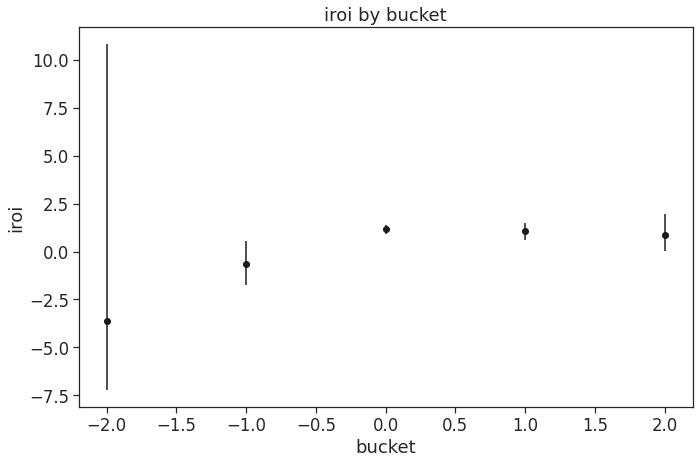

In [9]:
# Add a categorical feature 'bucket'
df_spark_with_bucket = df_spark.withColumn('bucket', F.col('feature_1').cast('int'))

df_iroi_per_bucket = estimate_and_plot_iroi_per_bucket(df_spark_with_bucket, 
                                             bucket_colname='bucket', 
                                             benefit_colname='benefit', 
                                             cost_colname='cost', 
                                             treatment_colname='treatment',
                                             bootstrap=True, 
                                             n_bootstraps=100)

# Retrospective estimation

### Convert Spark dataframe into H2O

In [10]:
df_h2o = context.asH2OFrame(df_spark, h2oFrameName = 'df_h2o')

### Train/Validation/Test Split

In [11]:
df_h2o_train, df_h2o_val, df_h2o_test = df_h2o.split_frame([0.50, 0.25])

### Define parameters

In [12]:
base_model_class = H2OGeneralizedLinearEstimator

model_params_cls = {'family': 'binomial'}

predictor_colnames = [col for col in df_spark.columns if col.startswith('feature')]

### Train the estimators and get predicted scores for test set

In [13]:
retrospective_estimator = RetrospectiveEstimator(base_model_class, model_params_cls, predictor_colnames, 
                                                 target_colname='outcome', treatment_colname='treatment', 
                                                 positive_outcome_value=1)

In [14]:
retrospective_estimator.fit(df_h2o_train, df_h2o_val)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [15]:
eval_colnames = ['treatment', 'outcome', 'benefit', 'cost']

In [16]:
df_h2o_test_eval = (
    df_h2o_test[eval_colnames]
    .cbind(retrospective_estimator.predict(df_h2o_test))
)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [17]:
df_spark_test_eval = context.asSparkFrame(df_h2o_test_eval)

### Evaluation

In [18]:
df_spark_test_eval.limit(10).toPandas()

,treatment,outcome,benefit,cost,score_re
0,1,0,0.000000,0.000000,0.424609
1,0,1,1.112169,0.000000,0.557832
2,0,1,2.628262,0.000000,0.467171
3,0,0,0.000000,0.000000,0.487724
4,1,1,4.389609,1.097402,0.503409
5,1,1,5.129260,1.282315,0.545769
6,0,1,2.331359,0.000000,0.493527
7,0,1,3.586888,0.000000,0.602938
8,0,1,3.797881,0.000000,0.638452
9,0,0,0.000000,0.000000,0.583919


#### iROI by predicted score quantiles

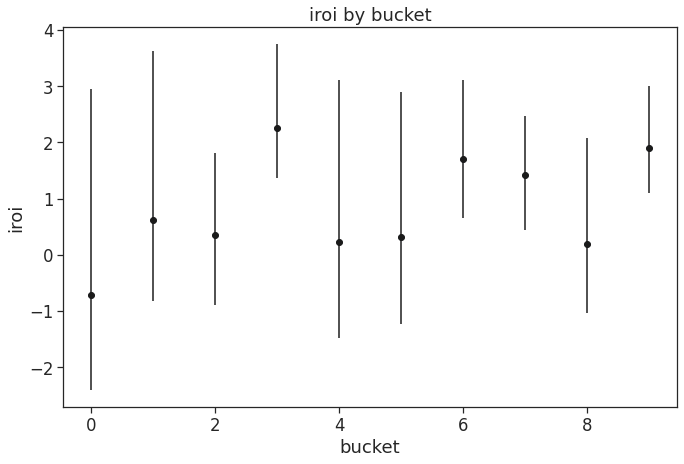

In [19]:
df_barplot, ax = estimate_and_plot_iroi_per_quantile(df_spark_test_eval, 
                                                    n_buckets=10, 
                                                    score_colname='score_re', 
                                                    benefit_colname='benefit',
                                                    cost_colname='cost',
                                                    treatment_colname='treatment', 
                                                    bootstrap=True, 
                                                    n_bootstraps=500)

#### Cumulative iROI

FixedFormatter should only be used together with FixedLocator
No handles with labels found to put in legend.


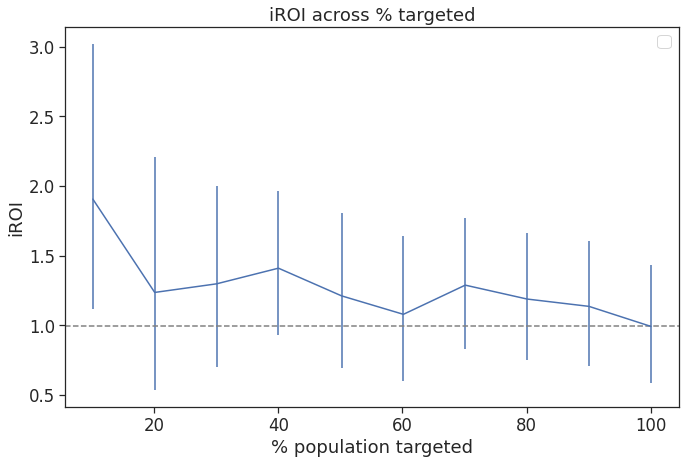

In [20]:
df_iroi, ax = estimate_and_plot_cum_iroi(df_spark_test_eval, 
                                        score_colname='score_re', 
                                        benefit_colname='benefit', 
                                        cost_colname='cost',
                                        treatment_colname='treatment', 
                                        n_buckets=10,
                                        bootstrap=True, 
                                        n_bootstraps=500)

In [21]:
df_iroi

,bucket,count,fraction,threshold,iroi,iroi_lower,iroi_upper,iroi_std_error
0,9.0,51,0.101594,0.644097,1.905993,1.116324,3.019839,0.495680
1,8.0,101,0.201195,0.615649,1.235630,0.534663,2.208694,0.427903
2,7.0,151,0.300797,0.595893,1.297381,0.696423,2.002522,0.332209
3,6.0,201,0.400398,0.580398,1.409831,0.932941,1.962082,0.286868
4,5.0,252,0.501992,0.563514,1.211096,0.696174,1.806090,0.285088
5,4.0,302,0.601594,0.549136,1.078337,0.596609,1.643535,0.272723
6,3.0,352,0.701195,0.530485,1.288016,0.825924,1.769441,0.239174
7,2.0,402,0.800797,0.501587,1.188086,0.747752,1.661865,0.227557
8,1.0,452,0.900398,0.468480,1.135494,0.708786,1.605876,0.226393
9,0.0,502,1.000000,-inf,0.991654,0.583150,1.431973,0.219316


#### Plotting with subplots

FixedFormatter should only be used together with FixedLocator
No handles with labels found to put in legend.


<AxesSubplot:title={'center':'iROI across % targeted'}, xlabel='% population targeted', ylabel='iROI'>

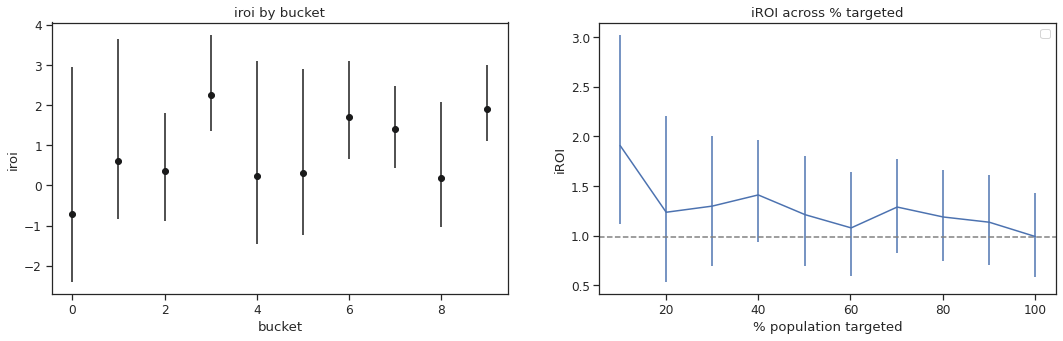

In [22]:
sns.set(font_scale=1.1, style='ticks', rc={'figure.figsize':(18, 5)})

fig, axes = plt.subplots(1, 2)

plot_metric_per_bucket(df_barplot,
                       y='iroi',
                       bootstrap=True, 
                       ax=axes[0])
    
plot_cum_iroi(df_iroi,
              bootstrap=True,
              ax=axes[1])